In [99]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
import numpy as np
from sklearn.model_selection import train_test_split
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Conv1D, MaxPooling1D, Flatten, Input
from pyswarm import pso
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [100]:
# Charger les données
data = pd.read_excel('Generated_Data_Greenhouse_Cherry_Tomato.xlsx')

# Afficher les premières lignes du dataset
data.head()

,Time,Saison,Stage_de_croissance,Type_de_varieté,Température_de_l_air,Humidité_relative,Radiation_solaire,CO2_atmosphérique,Humidité_du_sol,Température_du_sol,...,Concentration_en_N,Concentration_en_P,Concentration_en_K,Prévisions_météorologiques,Durée_d_irrigation,Type_de_système_d_irrigation,Quantité_d_eau,Nutriment_N,Nutriment_P,Nutriment_K
0,2018-06-01 00:00:00,Été,germination,Tomate cerise,25.000000,68.083932,429.813162,398.908873,26.216610,22.494077,...,26.735292,21.688968,42.342760,nuageux,16,goutte à goutte,2.874013,6.858343,4.611286,11.218657
1,2018-06-01 00:05:00,Été,germination,Tomate cerise,25.000000,66.524076,432.826195,400.206785,27.008811,22.399602,...,34.670274,21.758783,46.246242,nuageux,17,goutte à goutte,3.009311,6.832058,3.628102,11.223244
2,2018-06-01 00:10:00,Été,germination,Tomate cerise,25.177915,66.948370,467.994262,395.600546,26.800195,22.390696,...,29.332990,20.894561,32.243490,nuageux,10,goutte à goutte,2.596737,6.383663,3.405576,11.133005
3,2018-06-01 00:15:00,Été,germination,Tomate cerise,25.272447,68.584728,470.159768,398.223308,27.055201,22.538412,...,29.244443,24.792805,35.664553,nuageux,11,goutte à goutte,2.610331,8.628377,4.284347,8.929208
4,2018-06-01 00:20:00,Été,germination,Tomate cerise,25.562752,69.711461,451.819924,397.170334,29.045756,22.651368,...,37.966568,18.632431,33.966812,nuageux,15,goutte à goutte,3.056676,8.393613,4.635265,9.806661


In [101]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525601 entries, 0 to 525600
Data columns (total 22 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Time                          525601 non-null  object 
 1   Saison                        525601 non-null  object 
 2   Stage_de_croissance           525601 non-null  object 
 3   Type_de_varieté               525601 non-null  object 
 4   Température_de_l_air          525601 non-null  float64
 5   Humidité_relative             525601 non-null  float64
 6   Radiation_solaire             525601 non-null  float64
 7   CO2_atmosphérique             525601 non-null  float64
 8   Humidité_du_sol               525601 non-null  float64
 9   Température_du_sol            525601 non-null  float64
 10  Conductivité_électrique       525601 non-null  float64
 11  pH_du_sol                     525601 non-null  float64
 12  Concentration_en_N            525601 non-nul

In [102]:
# Convert 'Time' column to datetime format
data['Time'] = pd.to_datetime(data['Time'])

# Set 'Time' column as the index
data.set_index('Time', inplace=True)

# Define aggregation functions for each column
aggregation_functions = {
    'Saison': 'first',
    'Stage_de_croissance': 'first',
    'Type_de_varieté': 'first',
    'Température_de_l_air': 'mean',
    'Humidité_relative': 'mean',
    'Radiation_solaire': 'mean',
    'CO2_atmosphérique': 'mean',
    'Prévisions_météorologiques': 'first',
    'Humidité_du_sol': 'mean',
    'Température_du_sol': 'mean',
    'Conductivité_électrique': 'mean',
    'pH_du_sol': 'mean',
    'Concentration_en_N': 'mean',
    'Concentration_en_P': 'mean',
    'Concentration_en_K': 'mean',
    'Type_de_système_d_irrigation': 'first',
    'Durée_d_irrigation' : 'sum',
    'Quantité_d_eau': 'sum',
    'Nutriment_N': 'sum',
    'Nutriment_P': 'sum',
    'Nutriment_K': 'sum'
}

# Resample the data to daily frequency and apply the aggregation functions
df_daily = data.resample('D').agg(aggregation_functions)

# Reset the index to turn 'Time' back into a column
df_daily.reset_index(inplace=True)
df_daily.head(5)

,Time,Saison,Stage_de_croissance,Type_de_varieté,Température_de_l_air,Humidité_relative,Radiation_solaire,CO2_atmosphérique,Prévisions_météorologiques,Humidité_du_sol,...,pH_du_sol,Concentration_en_N,Concentration_en_P,Concentration_en_K,Type_de_système_d_irrigation,Durée_d_irrigation,Quantité_d_eau,Nutriment_N,Nutriment_P,Nutriment_K
0,2018-06-01,Été,germination,Tomate cerise,28.912275,63.587948,502.199668,419.137688,nuageux,21.514117,...,6.427196,32.236739,20.597904,40.304200,goutte à goutte,4190,763.307346,2137.047679,1155.962107,2887.874966
1,2018-06-02,Été,germination,Tomate cerise,30.189057,61.811955,495.650294,405.259800,nuageux,24.108542,...,6.306384,32.850936,20.870337,39.458074,goutte à goutte,4274,749.750928,2143.220672,1145.644007,2927.925612
2,2018-06-03,Été,germination,Tomate cerise,28.725985,56.046777,393.377639,362.973715,nuageux,18.075755,...,6.758241,32.742524,20.996351,40.111620,goutte à goutte,4175,758.137859,2138.365216,1161.394322,2875.154454
3,2018-06-04,Été,germination,Tomate cerise,32.484033,57.627080,399.106426,359.287191,nuageux,20.088684,...,6.779564,32.279327,21.079825,40.666012,goutte à goutte,4184,740.263542,2168.204802,1164.348768,2857.570399
4,2018-06-05,Été,germination,Tomate cerise,27.442690,59.153252,556.979301,376.705795,nuageux,26.478048,...,6.618230,32.869658,21.039457,40.292490,goutte à goutte,4221,743.841051,2183.520167,1143.040715,2884.878194


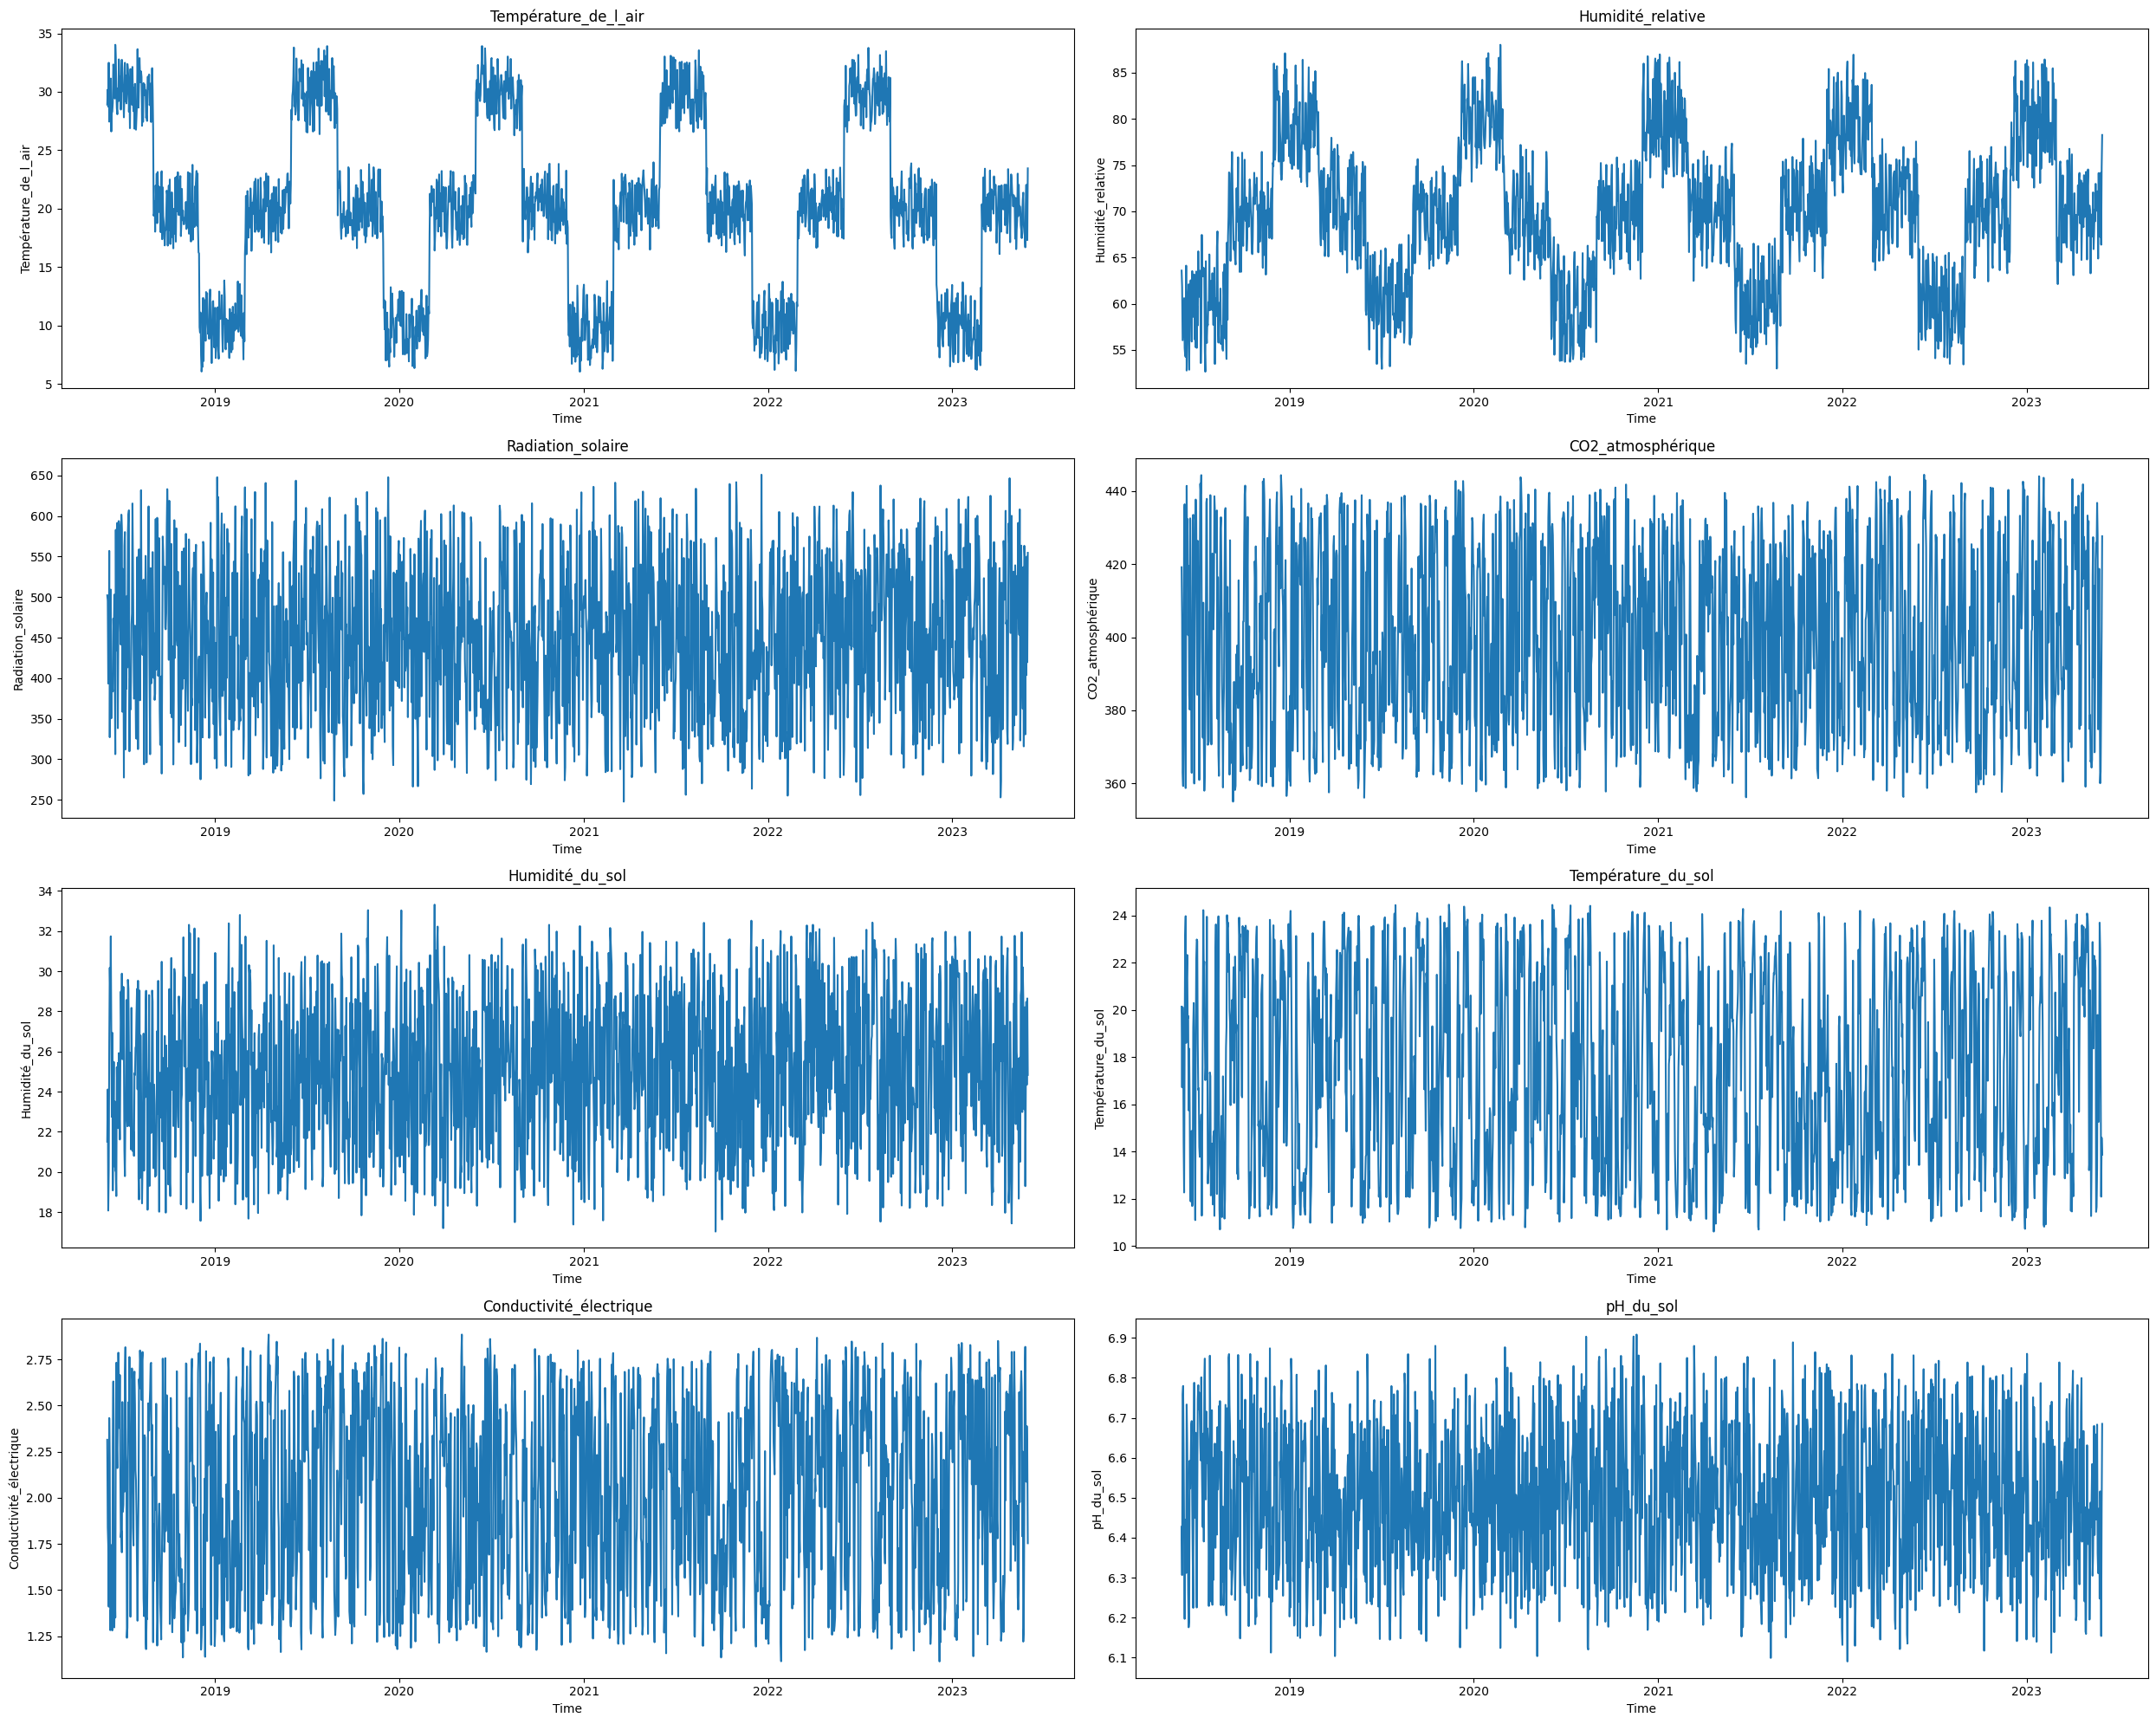

In [103]:
# Plot the time series for numerical features
numerical_features = [
    'Température_de_l_air', 'Humidité_relative', 'Radiation_solaire', 'CO2_atmosphérique',
    'Humidité_du_sol', 'Température_du_sol', 'Conductivité_électrique', 'pH_du_sol',
]

plt.figure(figsize=(25, 20))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(4, 2, i)
    plt.plot(df_daily['Time'], df_daily[feature])
    plt.title(feature)
    plt.xlabel('Time')
    plt.ylabel(feature)
    plt.tight_layout()

plt.show()

In [104]:
# Identifiez les colonnes de type 'object'
categorical_columns = df_daily.select_dtypes(include=['object']).columns

# Appliquez l'encodage one-hot
encoder = OneHotEncoder(sparse_output=False, drop='first')
encoded_categories = encoder.fit_transform(df_daily[categorical_columns])

# Créez un DataFrame pour les colonnes encodées
encoded_df = pd.DataFrame(encoded_categories, columns=encoder.get_feature_names_out(categorical_columns))

# Combinez les colonnes encodées avec le DataFrame d'origine
df_encoded = pd.concat([df_daily.drop(columns=categorical_columns), encoded_df], axis=1)
df_encoded.head(5)  

,Time,Température_de_l_air,Humidité_relative,Radiation_solaire,CO2_atmosphérique,Humidité_du_sol,Température_du_sol,Conductivité_électrique,pH_du_sol,Concentration_en_N,...,Nutriment_P,Nutriment_K,Saison_Hiver,Saison_Printemps,Saison_Été,Stage_de_croissance_floraison,Stage_de_croissance_fructification,Stage_de_croissance_germination,Prévisions_météorologiques_nuageux,Prévisions_météorologiques_pluvieux
0,2018-06-01,28.912275,63.587948,502.199668,419.137688,21.514117,20.137757,2.314499,6.427196,32.236739,...,1155.962107,2887.874966,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
1,2018-06-02,30.189057,61.811955,495.650294,405.259800,24.108542,16.716931,1.839490,6.306384,32.850936,...,1145.644007,2927.925612,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
2,2018-06-03,28.725985,56.046777,393.377639,362.973715,18.075755,20.114216,1.740914,6.758241,32.742524,...,1161.394322,2875.154454,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
3,2018-06-04,32.484033,57.627080,399.106426,359.287191,20.088684,19.041287,1.409661,6.779564,32.279327,...,1164.348768,2857.570399,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
4,2018-06-05,27.442690,59.153252,556.979301,376.705795,26.478048,14.352452,2.432022,6.618230,32.869658,...,1143.040715,2884.878194,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0


In [105]:
# Normalization
# scaler_features = MinMaxScaler()
# scaler_targets_water = MinMaxScaler()
# scaler_targets_N = MinMaxScaler()
# scaler_targets_P = MinMaxScaler()
# scaler_targets_K = MinMaxScaler()

# # Select the columns to normalize
# feature_columns = df_encoded.drop(columns=['Quantité_d_eau', 'Nutriment_N', 'Nutriment_P', 'Nutriment_K', 'Time']).columns
# # target_columns = ['Quantité_d_eau']

# # Normalize the features
# df_encoded[feature_columns] = scaler_features.fit_transform(df_encoded[feature_columns])

# # Normalize the targets
# df_encoded[['Quantité_d_eau']] = scaler_targets_water.fit_transform(df_encoded[['Quantité_d_eau']])
# df_encoded[['Nutriment_N']] = scaler_targets_N.fit_transform(df_encoded[['Nutriment_N']])
# df_encoded[['Nutriment_P']] = scaler_targets_P.fit_transform(df_encoded[['Nutriment_P']])
# df_encoded[['Nutriment_K']] = scaler_targets_K.fit_transform(df_encoded[['Nutriment_K']])

# df_encoded.head(5)

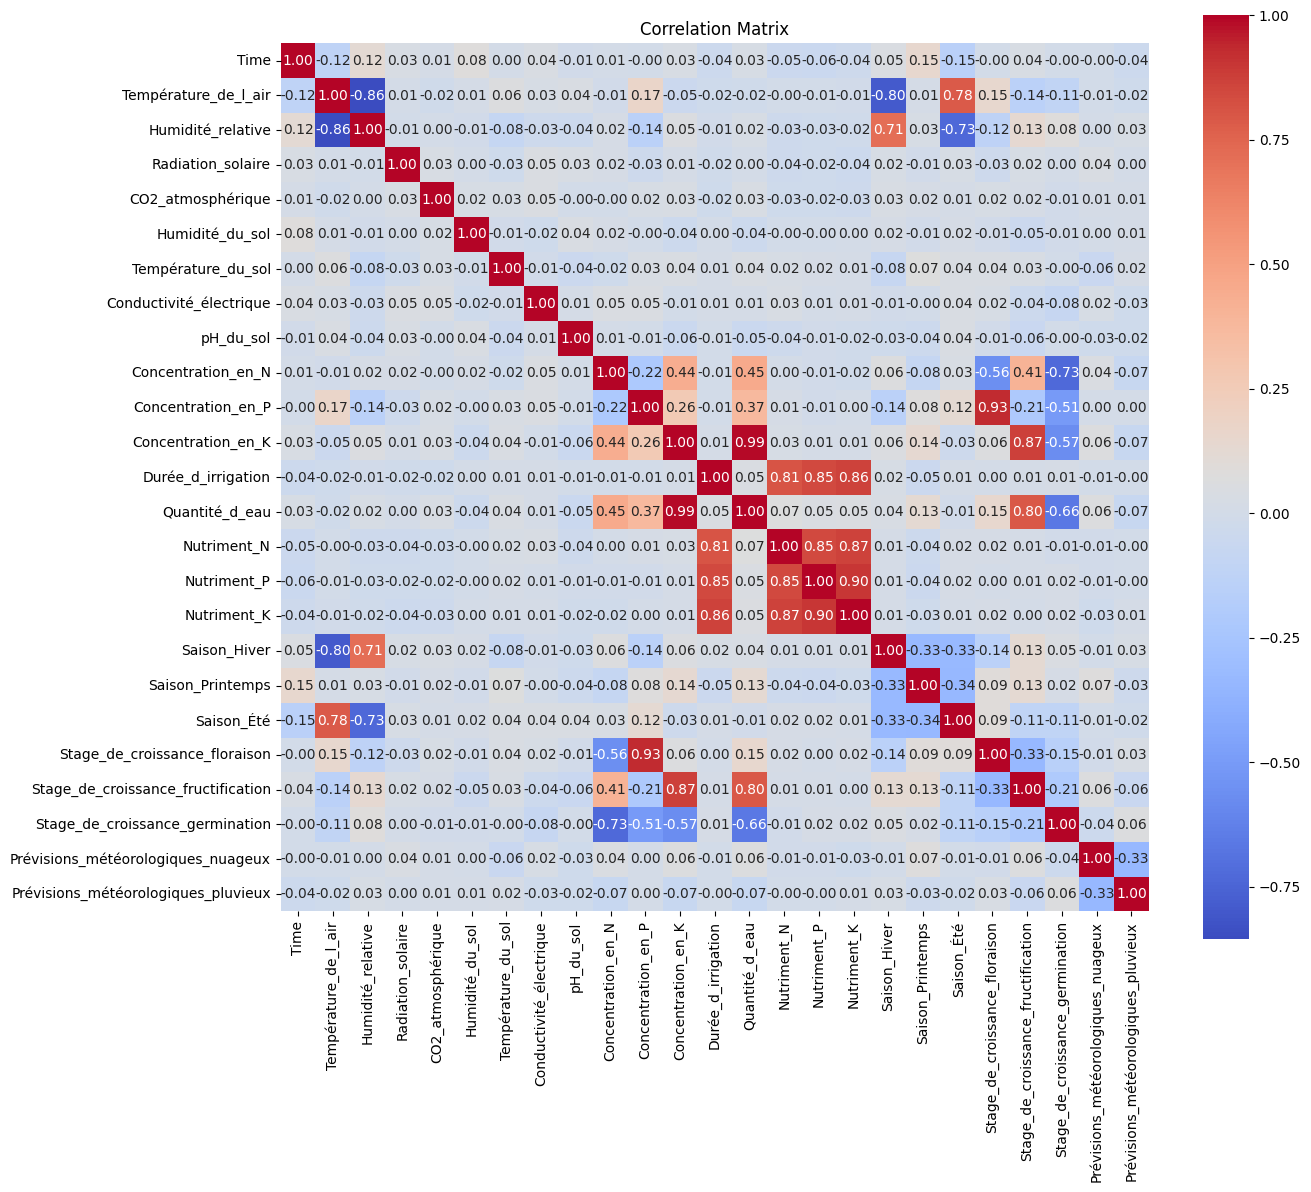

In [106]:
# Calculate the correlation matrix
correlation_matrix = df_encoded.corr()

plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', cbar=True, square=True)
plt.title('Correlation Matrix')
plt.show()

In [107]:
# Delete the specified columns
columns_to_delete = ['Concentration_en_K', "Durée_d_irrigation"]
df_encoded = df_encoded.drop(columns=columns_to_delete)

In [108]:
# Prepare data for Prophet
def prepare_prophet_data(data, target_column):
    df_prophet = data[['Time', target_column]].rename(columns={'Time': 'ds', target_column: 'y'})
    return df_prophet

In [133]:
# Fit and predict using Prophet
from prophet import Prophet

def prophet_forecast(data, target_column, steps=8):
    df_prophet = prepare_prophet_data(data, target_column)
    model = Prophet(interval_width=0.95, daily_seasonality=True)
    model.fit(df_prophet)
    future = model.make_future_dataframe(periods=steps, freq='D')
    forecast = model.predict(future)
    return forecast, model

In [121]:
# Plotting the forecast
def plot_prophet_forecast(forecast, target_column):
    plt.figure(figsize=(10, 6))
    plt.plot(forecast['ds'], forecast['yhat'], label='Forecast')
    plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], alpha=0.3)
    plt.title(f'Forecast for {target_column}')
    plt.xlabel('Date')
    plt.ylabel(target_column)
    plt.legend()
    plt.show()

In [138]:
def train_test_prophet(data, target_column, test_size=0.2):
    df_prophet = prepare_prophet_data(data, target_column)
    train_size = int(len(df_prophet) * (1 - test_size))
    train_data = df_prophet.iloc[:train_size]
    test_data = df_prophet.iloc[train_size:]
    
    # Train Prophet model
    model = Prophet()
    model.fit(train_data)
    
    # Create future dataframe
    future = model.make_future_dataframe(periods=len(test_data), freq='D')
    
    # Predict
    forecast = model.predict(future)
    
    return model, train_data, test_data, forecast

In [145]:
def evaluate_forecast(test_data, forecast):
    y_true = test_data['y'].values
    y_pred = forecast[-len(test_data):]['yhat'].values
    
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    
    print(f'MSE: {mse}')
    print(f'MAE: {mae}')
    print(f'RMSE: {rmse}')
    
    return mse, mae, rmse

In [140]:
target_column = 'Quantité_d_eau'
model, train_data, test_data, forecast = train_test_prophet(df_daily, target_column)

15:38:25 - cmdstanpy - INFO - Chain [1] start processing
15:38:25 - cmdstanpy - INFO - Chain [1] done processing


In [124]:
# forecast_water, model_water = prophet_forecast(df_encoded, 'Quantité_d_eau')
# forecast_N, model_N = prophet_forecast(df_encoded, 'Nutriment_N')
# forecast_P, model_P = prophet_forecast(df_encoded, 'Nutriment_P')
# forecast_K, model_K = prophet_forecast(df_encoded, 'Nutriment_K')

15:29:46 - cmdstanpy - INFO - Chain [1] start processing
15:29:46 - cmdstanpy - INFO - Chain [1] done processing
15:29:47 - cmdstanpy - INFO - Chain [1] start processing
15:29:47 - cmdstanpy - INFO - Chain [1] done processing
15:29:47 - cmdstanpy - INFO - Chain [1] start processing
15:29:48 - cmdstanpy - INFO - Chain [1] done processing
15:29:48 - cmdstanpy - INFO - Chain [1] start processing
15:29:49 - cmdstanpy - INFO - Chain [1] done processing


Evaluating forecast for Quantité_d_eau


15:40:50 - cmdstanpy - INFO - Chain [1] start processing
15:40:50 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\adila\anaconda3\envs\firma-env\lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\adila\anaconda3\envs\firma-env\lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


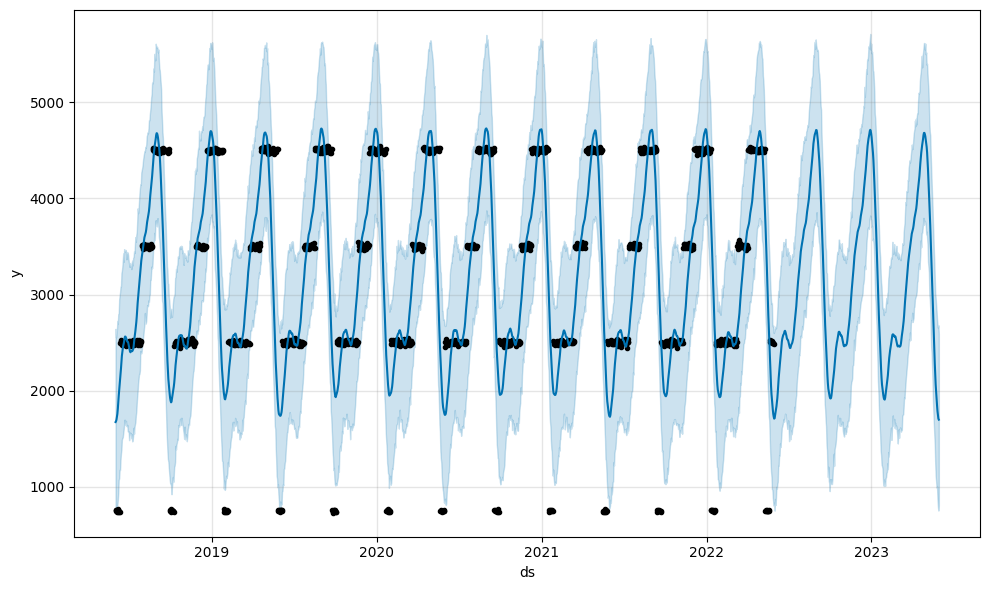

MSE: 1030696.5535221638
MAE: 604.8699193754251
RMSE: 1015.2322658003752
Evaluating forecast for Nutriment_N


15:40:51 - cmdstanpy - INFO - Chain [1] start processing
15:40:51 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\adila\anaconda3\envs\firma-env\lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\adila\anaconda3\envs\firma-env\lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


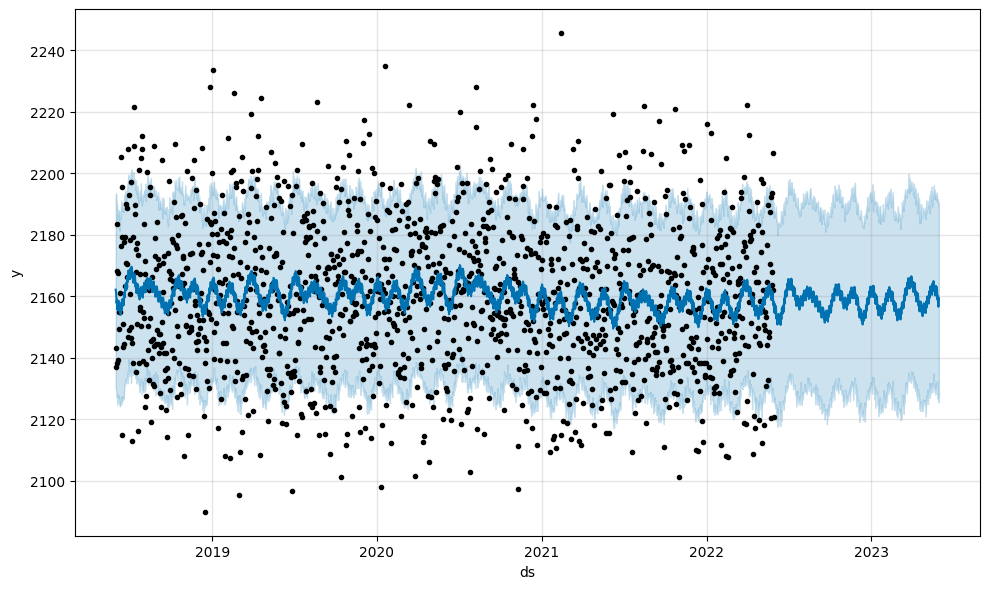

MSE: 13311.103637497936
MAE: 26.612911069151853
RMSE: 115.37375627714448
Evaluating forecast for Nutriment_P


15:40:52 - cmdstanpy - INFO - Chain [1] start processing
15:40:52 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\adila\anaconda3\envs\firma-env\lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\adila\anaconda3\envs\firma-env\lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


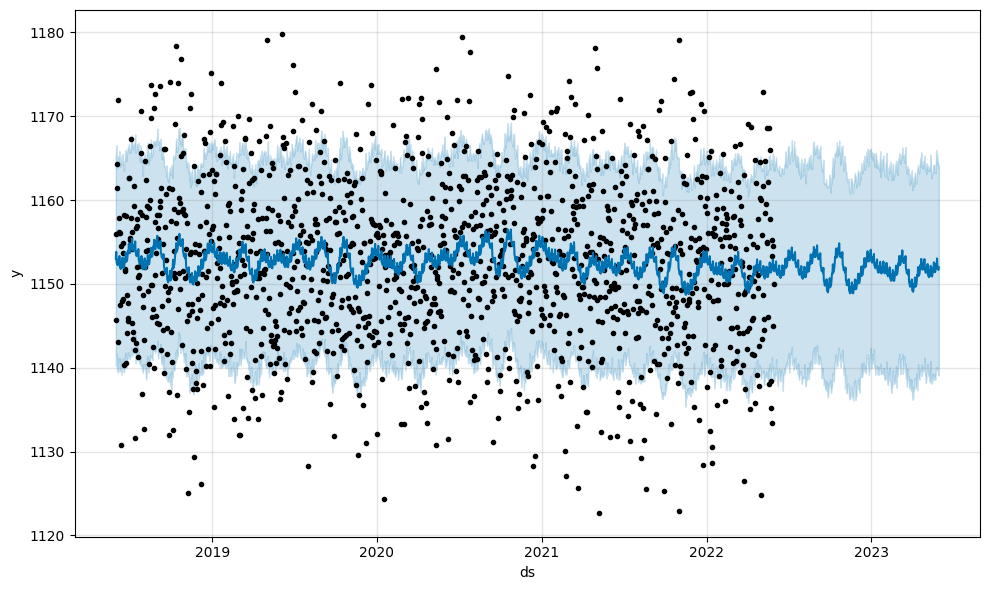

MSE: 3713.6718056415584
MAE: 11.82068940286665
RMSE: 60.939903229670115
Evaluating forecast for Nutriment_K


15:40:53 - cmdstanpy - INFO - Chain [1] start processing
15:40:53 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\adila\anaconda3\envs\firma-env\lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\adila\anaconda3\envs\firma-env\lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


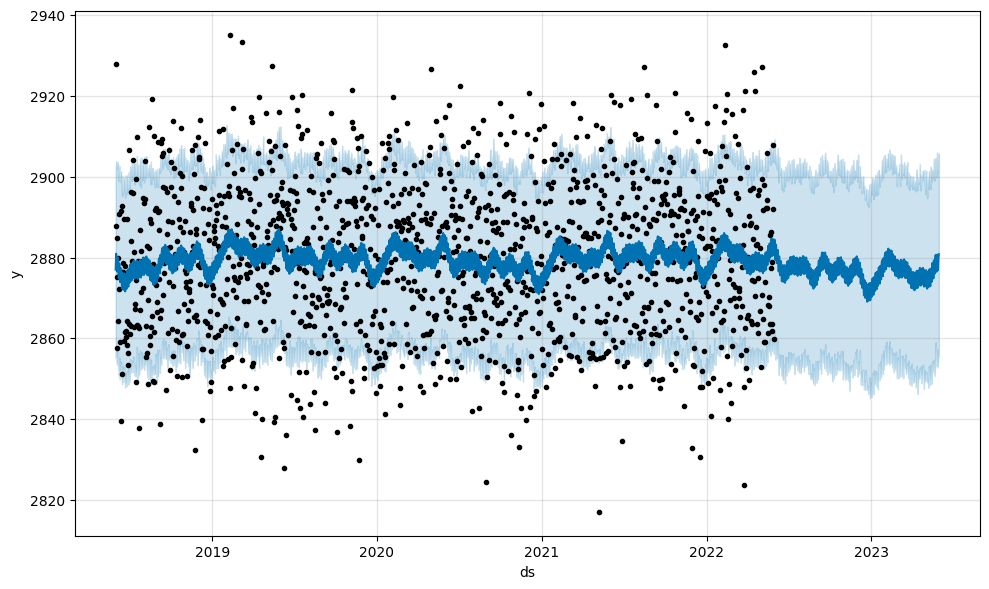

MSE: 22925.925129011976
MAE: 24.625796159294946
RMSE: 151.41309431159505


In [146]:
for target_column in ['Quantité_d_eau','Nutriment_N', 'Nutriment_P', 'Nutriment_K']:
    print(f"Evaluating forecast for {target_column}")
    model, train_data, test_data, forecast = train_test_prophet(df_daily, target_column)
    
    # Plot the forecast
    fig = model.plot(forecast)
    plt.show()
    
    # Evaluate the forecast
    evaluate_forecast(test_data, forecast)

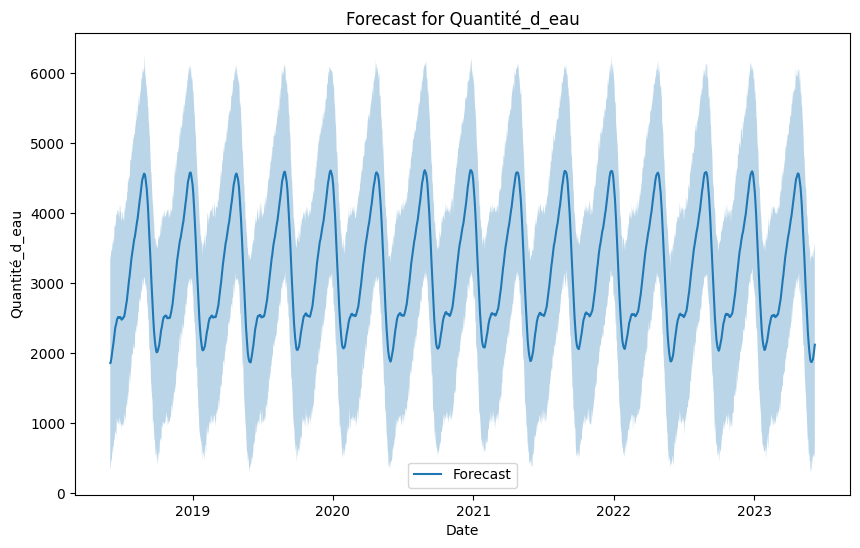

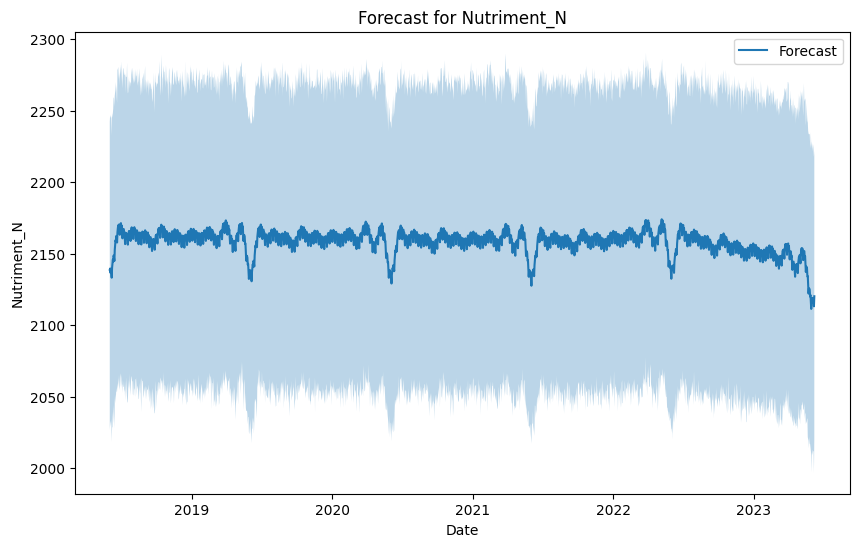

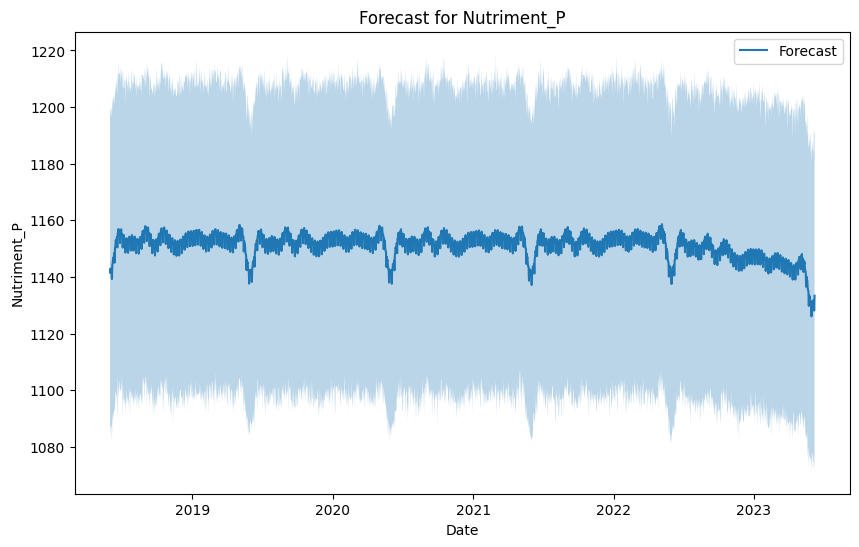

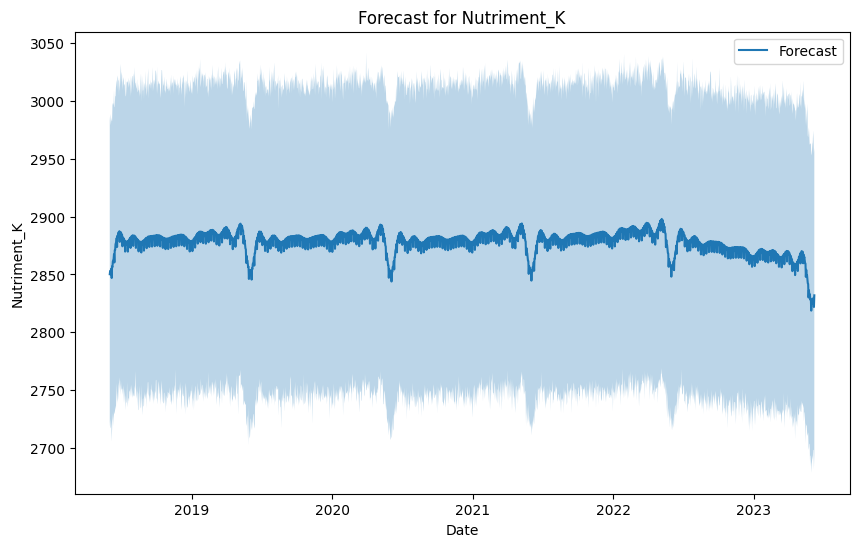

In [125]:
plot_prophet_forecast(forecast_water, 'Quantité_d_eau')
plot_prophet_forecast(forecast_nutrient_n, 'Nutriment_N')
plot_prophet_forecast(forecast_nutrient_p, 'Nutriment_P')
plot_prophet_forecast(forecast_nutrient_k, 'Nutriment_K')

In [126]:
future_water = model_water.make_future_dataframe(periods=8, freq='D')
future_N = model_N.make_future_dataframe(periods=8, freq='D')
future_P = model_P.make_future_dataframe(periods=8, freq='D')
future_K = model_K.make_future_dataframe(periods=8, freq='D')

forecast_water = model_water.predict(future_water)
forecast_N = model_N.predict(future_N)
forecast_P = model_P.predict(future_P)
forecast_K = model_K.predict(future_K)

forecast = pd.concat([forecast_water[['ds', 'yhat']], forecast_N['yhat'], forecast_P['yhat'], forecast_K['yhat']], axis=1)
forecast.columns = ['Date', 'Quantité_d_eau', 'Nutriment_N', 'Nutriment_P', 'Nutriment_K']
forecast.tail(8)


# forcast_water_unscaled = forecast_water.copy()[['ds', 'yhat']]
# forcast_N_unscaled = forecast_N.copy()[['ds', 'yhat']]
# forcast_P_unscaled = forecast_P.copy()[['ds', 'yhat']]
# forcast_K_unscaled = forecast_water.copy()[['ds', 'yhat']]

# forcast_water_unscaled['yhat'] = scaler_targets_water.inverse_transform(forcast_water_unscaled[['yhat']])
# forcast_N_unscaled['yhat'] = scaler_targets_N.inverse_transform(forcast_N_unscaled[['yhat']])
# forcast_P_unscaled['yhat'] = scaler_targets_P.inverse_transform(forcast_P_unscaled[['yhat']])
# forcast_K_unscaled['yhat'] = scaler_targets_K.inverse_transform(forcast_K_unscaled[['yhat']])

# # concatinate the datasets
# forcast_water_unscaled.rename(columns={'ds': 'Date', 'yhat': 'Quantité_d_eau'}, inplace=True)
# forcast_N_unscaled.rename(columns={'ds': 'Date', 'yhat': 'Nutriment_N'}, inplace=True)
# forcast_P_unscaled.rename(columns={'ds': 'Date', 'yhat': 'Nutriment_P'}, inplace=True)
# forcast_K_unscaled.rename(columns={'ds': 'Date', 'yhat': 'Nutriment_K'}, inplace=True)

# forcast_unscaled = pd.concat([forcast_water_unscaled, forcast_N_unscaled['Nutriment_N'], forcast_P_unscaled['Nutriment_P'], forcast_K_unscaled['Nutriment_K']], axis=1)

# forcast_unscaled.tail(8)

,Date,Quantité_d_eau,Nutriment_N,Nutriment_P,Nutriment_K
1826,2023-06-01,1889.018200,2116.606320,1130.609354,2826.777047
1827,2023-06-02,1899.818006,2118.048269,1130.188244,2824.402702
1828,2023-06-03,1909.444763,2119.082073,1131.626280,2827.512289
1829,2023-06-04,1943.638388,2116.156251,1130.341903,2827.255242
1830,2023-06-05,1984.268724,2119.112750,1130.706404,2826.852794
1831,2023-06-06,2030.725449,2116.493959,1131.879807,2829.769593
1832,2023-06-07,2069.326195,2113.237279,1128.157945,2821.821527
1833,2023-06-08,2120.321758,2120.274307,1133.405439,2831.916648


c:\Users\adila\anaconda3\envs\firma-env\lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\adila\anaconda3\envs\firma-env\lib\site-packages\prophet\plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
c:\Users\adila\anaconda3\envs\firma-env\lib\site-packages\prophet\plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an 

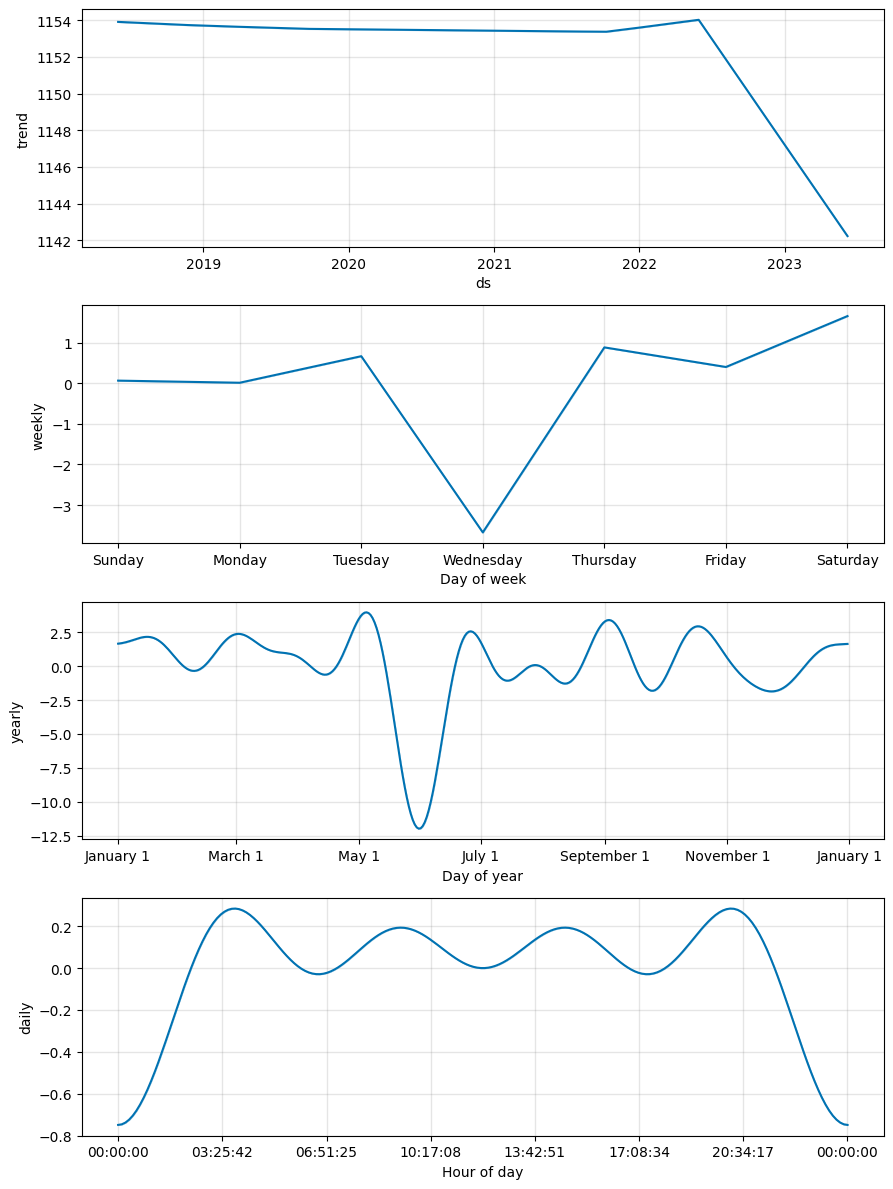

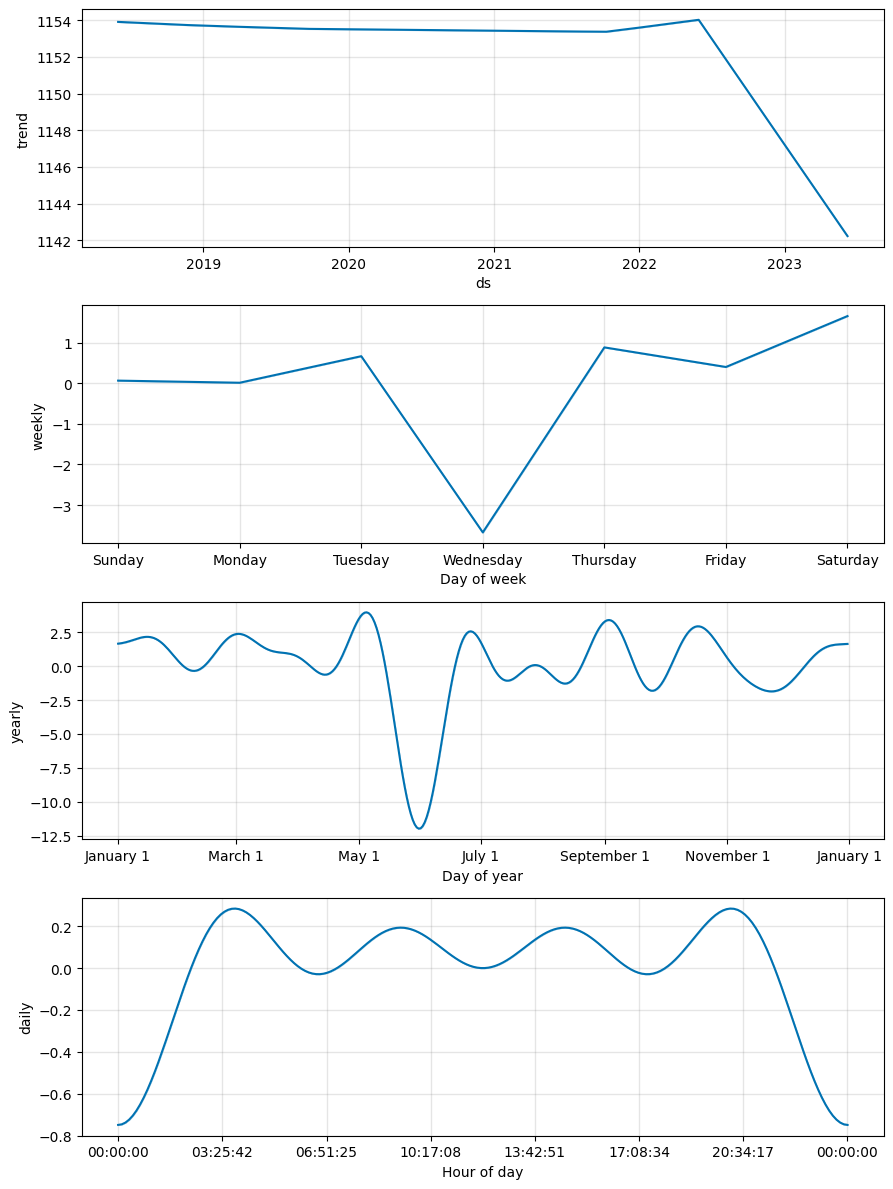

In [151]:
model_P.plot_components(forecast_P)

In [116]:
# Forecast evaluation
def evaluate_forecast(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mse = mean_squared_error(y_true, y_pred)
    print(f'MAE: {mae}, RMSE: {rmse}, MSE: {mse}')
    return mae, rmse, mse